# Approximate Factor Models

_It is better to be vaguely right than precisely wrong_ - Carveth Read

- Integration Order
- Approximate factor model


References:

- Bai, Jushan and Ng, Serena, 2002, Determining the Number of Factors in Approximate Factor Models, Econometrica 70:1, 191-2211

- McCracken, Michael W., and Serena Ng, 2016. FRED-MD: A monthly database for macroeconomic research, Journal of Business & Economic Statistics, 34(4), 574-589.

- Michael W. McCracken, Serena Ng, 2020, FRED-QD: A Quarterly Database for Macroeconomic Research.


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from finds.readers import Alfred, fred_md, fred_qd
from finds.recipes import (approximate_factors, mrsq, select_baing, integration_order,
                           remove_outliers, is_outlier)
from secret import credentials
VERBOSE = 0
#%matplotlib qt

In [2]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)

In [3]:
## Retrieve recession periods from FRED
vspans = alf.date_spans('USREC')
DataFrame(vspans, columns=['Start', 'End'])

,Start,End
0,1854-12-31,1854-12-31
1,1857-06-30,1858-12-31
2,1860-10-31,1861-06-30
3,1865-04-30,1867-12-31
4,1869-06-30,1870-12-31
5,1873-10-31,1879-03-31
6,1882-03-31,1885-05-31
7,1887-03-31,1888-04-30
8,1890-07-31,1891-05-31
9,1893-01-31,1894-06-30


## Integration order

### Augmented Dickey-Fuller test

The Augmented Dickey-Fuller (ADF) specification is the most widely used unit root test. An ADF test is implemented using an OLS regression where the difference of a series is regressed on its lagged level, relevant deterministic terms, and lagged differ-ences. The general form of an ADF regression is

$$\Delta Y_t = \gamma Y_{t-1} + (\delta_o + \delta_1 t) +  \lambda_1 \Delta Y_{t-1} +  ... + \lambda_p \Delta Y_{t-p}$$

The balue of $\gamma$ is 0 when $Y_t$ is a random walk, and so is non-stationary.  The alternative is $\gamma < 0$ which corresponds to the case that $Y_t$ is covariance-stationary.  Note that the alternative is one-sided, since positive values of $\gamma$ correspond to an AR coefficient that is larger than 1.

When the null of a unit root cannot be rejected, the series should be differenced. The best practice is to repeat the ADF test on the iteratively-differenced data to ensure that it is stationary. 


In [4]:
qd_df, qd_codes = fred_qd() # 202004
md_df, md_codes = fred_md() # 201505
qd_date = max(qd_df.index)
md_date = max(md_df.index)

FRED-QD vintage: quarterly/current.csv
FRED-MD vintage: monthly/current.csv


### Transformations

FRED-MD and FRED-QD series are tagged by one of seven transformation codes, which suggest transformations, such as taking logs or differences, to apply to the underlying series.  The number of times differences are taken of a series should remove unit roots and transform the series to be covariance stationary.

In [5]:
print(f"Number of series by suggested tcode transformations ({md_date}):")
tcodes = DataFrame.from_dict({i: alf.tcode[i] for i in range(1, 8)},
                             orient='index')\
                  .join(qd_codes['transform'].value_counts().rename('fred-qd'))\
                  .join(md_codes['transform'].value_counts().rename('fred-md'))\
                  .fillna(0)\
                  .astype(int)\
                  .rename_axis(index='tcode')
tcodes

Number of series by suggested tcode transformations (20240331):


,diff,log,pct_change,fred-qd,fred-md
tcode,,,,,
1,0,0,0,22,11
2,1,0,0,32,19
3,2,0,0,0,0
4,0,1,0,0,10
5,1,1,0,140,52
6,2,1,0,50,33
7,1,0,1,1,1


In [6]:
# For each series, compare fitted integration order with tcode
out = {}
stationary_out = {}
for label, df, transforms in [['md', md_df, md_codes['transform']],
                              ['qd', qd_df, qd_codes['transform']]]:
    stationary = dict()
    for series_id, tcode in transforms.items():
        # apply transformation if series tcode is valid
        if tcode in range(1, 8):
            # take logs of series if specified by tcode
            s = np.log(df[series_id]) if tcode in [4, 5, 6] else df[series_id]

            # estimate integration order
            order = integration_order(s.dropna(), pvalue=0.05)

            # expected order specified by tcode
            expected_order = 2 if tcode == 7 else ((tcode - 1) % 3)

            # accumulate results for this series
            stationary[series_id] = {'tcode': tcode,
                                     'I(p)': order,
                                     'different': order - expected_order,
                                     'title': alf.header(series_id)}
#            print(series_id, tcode, expected_order, order)

    # collect results for display
    stationary = DataFrame.from_dict(stationary, orient='index')
    stationary = stationary.sort_values(stationary.columns.to_list())
    c = stationary.groupby(['tcode','I(p)'])['title'].count().reset_index()
    out[label] = c.pivot(index='tcode', columns='I(p)', values='title')\
                  .fillna(0).astype(int)
    out[label].columns=[f"I({p})" for p in out[label].columns]
    stationary_out[label] = stationary[stationary['different'] > 0]

In [7]:
print('Series by tcode, transformations and estimated order of integration:')
results = pd.concat([tcodes.drop(columns='fred-md'),
                     out['qd'],
                     tcodes['fred-md'],
                     out['md']], axis=1).fillna(0).astype(int)
print('Integration order by transformation')
results

Series by tcode, transformations and estimated order of integration:
Integration order by transformation


,diff,log,pct_change,fred-qd,I(0),I(1),I(2),fred-md,I(0),I(1),I(2)
tcode,,,,,,,,,,,
1,0,0,0,22,18,4,0,11,11,0,0
2,1,0,0,32,11,19,2,19,4,15,0
3,2,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,10,6,4,0
5,1,1,0,140,30,106,4,52,14,38,0
6,2,1,0,50,0,30,20,33,0,30,3
7,1,0,1,1,0,1,0,1,0,1,0


In [8]:
print('FRED-MD Series with unit root after transformation')
stationary_out['md']

FRED-MD Series with unit root after transformation


,tcode,I(p),different,title
PERMITMW,4,1,1,New Privately-Owned Housing Units Authorized i...
PERMITNE,4,1,1,New Privately-Owned Housing Units Authorized i...
HOUSTMW,4,1,1,New Privately-Owned Housing Units Started: Tot...
HOUSTNE,4,1,1,New Privately-Owned Housing Units Started: Tot...


In [9]:
print('FRED-QD Series with unit root after transformation')
stationary_out['qd']

FRED-QD Series with unit root after transformation


,tcode,I(p),different,title
NWPI,1,1,1,*** NWPI ***
TLBSNNBBDI,1,1,1,*** TLBSNNBBDI ***
TLBSNNCBBDI,1,1,1,*** TLBSNNCBBDI ***
HWI,1,1,1,Help Wanted Index for United States
GFDEBTN,2,2,1,Federal Debt: Total Public Debt
S&P div yield,2,2,1,S&P's Composite Common Stock: Dividend Yield
CES2000000008,5,2,1,Average Hourly Earnings of Production and Nons...
TLBSHNO,5,2,1,Households and Nonprofit Organizations; Total ...
OPHMFG,5,2,1,Manufacturing Sector: Labor Productivity (Outp...
SPCS20RSA,5,2,1,S&P CoreLogic Case-Shiller 20-City Composite H...


## Approximate factor model

__Principal component analysis__ finds a low-dimensional representation of a data set that contains as much as possible of the variation of its $p$ features.
Each of the dimensions found by PCA is a linear
combination of the features. The first principal component of a set
of features $X_1, X_2,..., X_p$ is the normalized linear combination
of the features $Z_1 = \phi_{11} X_1 + \phi_{21} X_2 + ... + \phi_{p1}                                
X_p$ that has the largest variance. We can then iteratively find the second principal
component $Z_2$ (the linear combination of features that has maximal
variance out of all linear combinations that are uncorrelated with
previously found components), third component $Z_3$, and so on.


### BIC criterion

Select number of components

### Data imputation

EM algorithm

In [10]:
# Verify BaiNg implemention on original FRED-MD and FRED-QD
qd_df, qd_codes = fred_qd(202004)
md_df, md_codes = fred_md(201505)
for freq, df, transforms in [['monthly', md_df, md_codes['transform']],
                             ['quarterly', qd_df, qd_codes['transform']]]:    
    # Apply tcode transformations
    transformed = []
    for col in df.columns:
        transformed.append(alf.transform(df[col],
                                         tcode=transforms[col],
                                         freq=freq[0]))
    data = pd.concat(transformed, axis=1).iloc[2:]
    cols = list(data.columns)
    sample = data.index[((np.count_nonzero(np.isnan(data), axis=1)==0)
                         | (data.index <= 20141231))
                        & (data.index >= 19600301)]

    # set missing and outliers to NaN
    x = data.loc[sample]
    x = remove_outliers(x)    # default fence 'iq10' is 10 times IQ 

    # compute factors EM and auto select number of components, r
    Z = approximate_factors(x, p=2, verbose=VERBOSE)
    r = select_baing(Z, p=2)

    # show marginal R2's of series to each component
    mR2 = mrsq(Z, r).to_numpy()
    print(f"FRED-{freq[0].upper()}D {freq} series:")
    print(DataFrame({'selected': r,
                     'variance explained': np.sum(np.mean(mR2[:, :r], axis=0)),
                     'start': min(sample),
                     'end': max(sample),
                     'obs': Z.shape[0],
                     'series': Z.shape[1]},
                    index=[f'factors']))

    for k in range(r):
        args = np.argsort(-mR2[:, k])
        print(f"Factor:{1+k} Variance Explained={np.mean(mR2[:,k]):.4f}")
        print(DataFrame.from_dict({mR2[arg, k].round(4):
                                   {'series': cols[arg],
                                    'description': alf.header(cols[arg])}
                                   for arg in args[:10]},
                                  orient='index'))

FRED-QD vintage: quarterly/2020-04.csv
FRED-MD vintage: monthly/2015-05.csv
FRED-MD monthly series:
         selected  variance explained     start       end  obs  series
factors         8            0.484228  19600331  20141231  658     133
Factor:1 Variance Explained=0.1625
           series                                 description
0.7426     USGOOD              All Employees, Goods-Producing
0.7236     PAYEMS                All Employees, Total Nonfarm
0.6999     MANEMP                All Employees, Manufacturing
0.6563       NAPM                                *** NAPM ***
0.6538  IPMANSICS  Industrial Production: Manufacturing (SIC)
0.6510    DMANEMP                All Employees, Durable Goods
0.6312     INDPRO          Industrial Production: Total Index
0.6036    NAPMNOI                             *** NAPMNOI ***
0.6024     NAPMPI                              *** NAPMPI ***
0.5601     CUMFNS   Capacity Utilization: Manufacturing (SIC)
Factor:2 Variance Explained=0.0705
      

In [11]:
# Compute approximate factors from current FRED-MD
data, t = fred_md()    # fetch dataframe of current fred-md and transform codes
data.index = pd.to_datetime(data.index, format='%Y%m%d')
transforms = t['transform']
data = pd.concat([alf.transform(data[col], tcode=transforms[col], freq='m')
                  for col in data.columns],  axis=1)

# remove outliers and impute using Bai-Ng approach
r = 8   # fix number of factors = 8
X = remove_outliers(data, method='farout')
X = approximate_factors(X, kmax=r, p=0, verbose=VERBOSE)

FRED-MD vintage: monthly/current.csv


Recover factors as the projections from PCA

In [12]:
# Extract factors from PCA projections on imputed data
y = StandardScaler().fit_transform(X)
pca = PCA(n_components=r).fit(y)
factors = DataFrame(pca.transform(y), index=data.index, columns=range(1, 1+r))

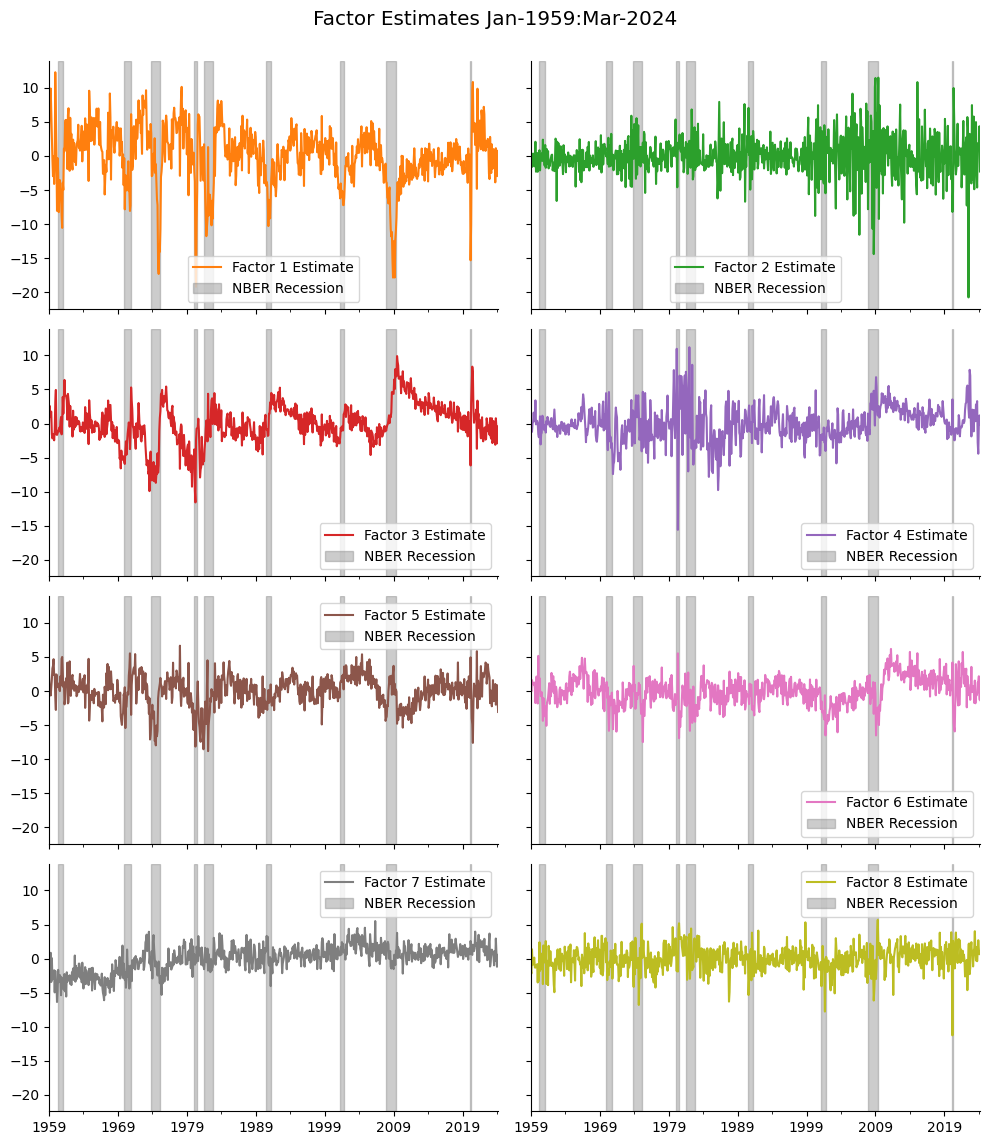

In [13]:
# Plot extracted factors
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey=True)
axes = axes.flatten()
for col, ax in zip(factors.columns, axes):
    flip = -np.sign(max(factors[col]) + min(factors[col])) # try match sign
    (flip*factors[col]).plot(ax=ax, color=f"C{col}")
    for a,b in vspans:
        if b >= min(factors.index):
            ax.axvspan(max(a, min(factors.index)),
                       min(b, max(factors.index)),
                       alpha=0.4,
                       color='grey')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend([f"Factor {col} Estimate", 'NBER Recession'])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Factor Estimates {factors.index[0]:%b-%Y}:"
             f"{factors.index[-1]:%b-%Y}", fontsize='x-large')
plt.show()